In [1]:
import os
import zipfile
import pandas as pd

# Module constants
DATASET_DIR = os.path.join(os.getcwd(), 'datasets')
TRAINING_CSV =  os.path.join(DATASET_DIR, 'train.csv')
TEST_CSV = os.path.join(DATASET_DIR, 'test.csv')
DATA_ZIP = os.path.join(DATASET_DIR, 'all.zip')

# get dataset if flat file not readily available
def get_csv_from_zip(train_set=True):
    csv = TRAINING_CSV if train_set else TEST_CSV

    with zipfile.ZipFile(DATA_ZIP) as data_zip:
        member = 'train.csv' if train_set else 'test.csv'
        data_zip.extract(member, path=DATASET_DIR)

# load data via pandas
def load_dataset(csv=TRAINING_CSV):
    if not os.path.isfile(csv):
        get_csv_from_zip()

    return pd.read_csv(csv)

In [4]:
# Explore the data
train_set = load_dataset()
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
# Name, Sex, Ticket, Cabin, and Embarked are non-numeric features
# Additinally, cabin, age, and embarked have incomplete data for some passangers
# Note - Name, Ticket, and Cabin seem irrelevant 

categorical_feat = list(train_set.select_dtypes(include='object').columns)
print(train_set['Sex'].value_counts())
print()
print(train_set['Embarked'].value_counts())

male      577
female    314
Name: Sex, dtype: int64

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [6]:
# Get summary of numerical features
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
# look for correlation of numerical features to survival
corr_matrix = train_set.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [9]:
# Prepare data for ML Algorithms
# update 'Sex' and 'Embarked' dtype to 'category'
titanic_tr = train_set.astype({'Sex': 'category', 'Embarked': 'category'})
titanic_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null category
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null category
dtypes: category(2), float64(2), int64(5), object(3)
memory usage: 71.6+ KB


In [10]:
# Drop PassengerID, Name, Ticket, and Cabin features
titanic_tr = titanic_tr.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [11]:
# recode Sex
titanic_tr['Sex'] = titanic_tr['Sex'].cat.codes
titanic_tr.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
# one hot encode Embark and then drop original
one_hot_encode = pd.get_dummies(titanic_tr['Embarked'], prefix='Embarked', dtype=int)
titanic_tr = titanic_tr.join(other=one_hot_encode)
titanic_tr = titanic_tr.drop('Embarked', axis=1)
titanic_tr.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,0.188552,0.086420,0.722783
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.391372,0.281141,0.447876
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


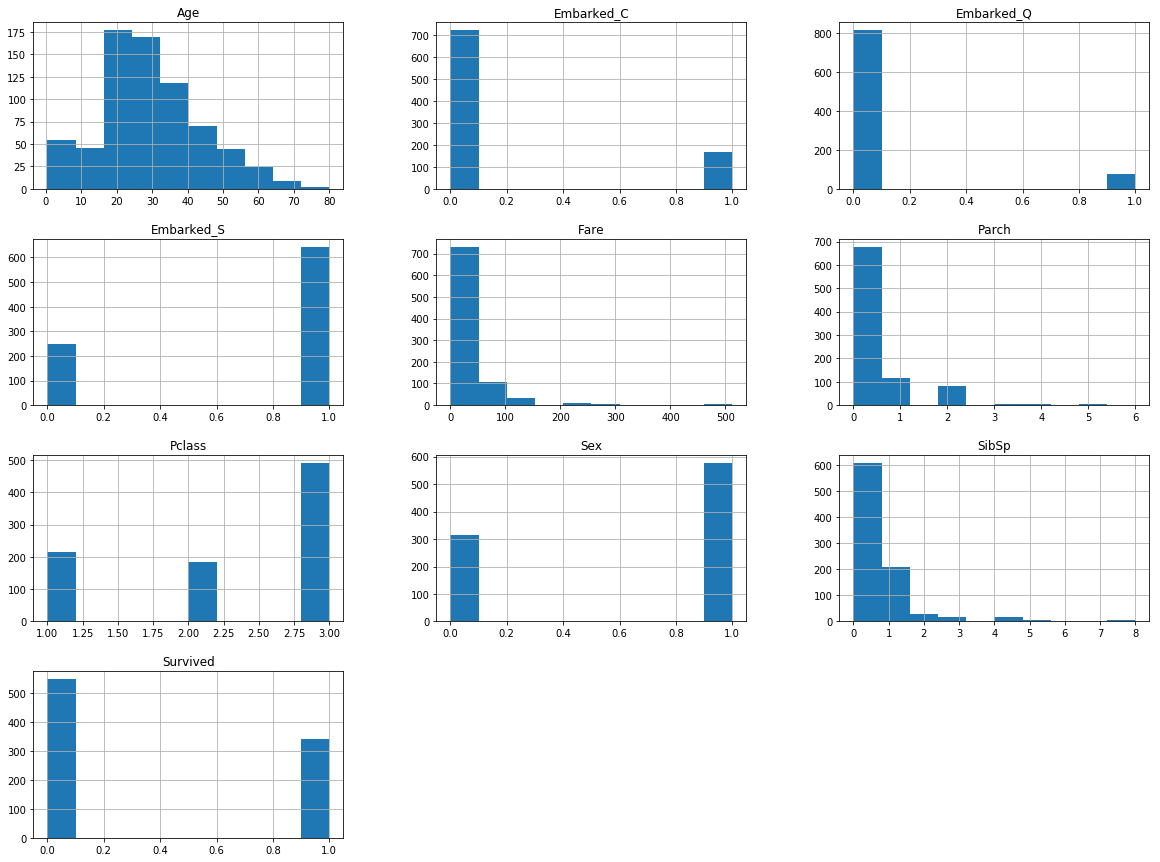

In [13]:
titanic_tr.hist(bins=10, figsize=(20, 15))
plt.show()

In [14]:
# Age has missing values - set the value to the median
titanic_tr['Age'] = titanic_tr['Age'].fillna(titanic_tr['Age'].median())
titanic_tr.describe()

# NOTE - should consider/attempt to predict missing age values as an alterntive to using median
# This on its own could be specific kernal to post on Kaggle - how the different methods populating missing
# data affects the predictive ability of the model.

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.361582,0.523008,0.381594,32.204208,0.188552,0.086420,0.722783
std,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,0.391372,0.281141,0.447876
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


In [15]:
# Feature scaling
# Pclass, Age, SibSp, Parch, and Fare need to be scaled to 0 - 1 range
# Note - will use standardization for scaling because of outlier effects

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
titanic_scaled = pd.DataFrame(scaler.fit_transform(titanic_tr), columns=titanic_tr.columns)
titanic_scaled.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000,8.910000e+02
mean,3.987333e-17,-8.772133e-17,-1.156327e-16,2.272780e-16,4.386066e-17,5.382900e-17,3.987333e-18,-1.993666e-17,0.000000,-4.984166e-17
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562,1.000562e+00
min,-7.892723e-01,-1.566107e+00,-1.355574e+00,-2.224156e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01,-4.820427e-01,-0.307562,-1.614710e+00
25%,-7.892723e-01,-3.693648e-01,-1.355574e+00,-5.657365e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01,-4.820427e-01,-0.307562,-1.614710e+00
50%,-7.892723e-01,8.273772e-01,7.376951e-01,-1.046374e-01,-4.745452e-01,-4.736736e-01,-3.573909e-01,-4.820427e-01,-0.307562,6.193064e-01
75%,1.266990e+00,8.273772e-01,7.376951e-01,4.333115e-01,4.327934e-01,-4.736736e-01,-2.424635e-02,-4.820427e-01,-0.307562,6.193064e-01
max,1.266990e+00,8.273772e-01,7.376951e-01,3.891554e+00,6.784163e+00,6.974147e+00,9.667167e+00,2.074505e+00,3.251373,6.193064e-01


In [16]:
# look for correlation of numerical features to survival
corr_matrix = titanic_scaled.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived      1.000000
Fare          0.257307
Embarked_C    0.168240
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.064910
Embarked_S   -0.155660
Pclass       -0.338481
Sex          -0.543351
Name: Survived, dtype: float64

In [41]:
# Food for thought: what is the relationship between Pclass and Fare?
# Extension: what is the relationship across all features
corr_matrix


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,-0.338481,-0.543351,-0.064910,-0.035322,0.081629,0.257307,0.168240,0.003650,-0.155660
Pclass,-0.338481,1.000000,0.131900,-0.339898,0.083081,0.018443,-0.549500,-0.243292,0.221009,0.081720
Sex,-0.543351,0.131900,1.000000,0.081163,-0.114631,-0.245489,-0.182333,-0.082853,-0.074115,0.125722
Age,-0.064910,-0.339898,0.081163,1.000000,-0.233296,-0.172482,0.096688,0.030248,-0.031415,-0.014665
SibSp,-0.035322,0.083081,-0.114631,-0.233296,1.000000,0.414838,0.159651,-0.059528,-0.026354,0.070941
Parch,0.081629,0.018443,-0.245489,-0.172482,0.414838,1.000000,0.216225,-0.011069,-0.081228,0.063036
Fare,0.257307,-0.549500,-0.182333,0.096688,0.159651,0.216225,1.000000,0.269335,-0.117216,-0.166603
Embarked_C,0.168240,-0.243292,-0.082853,0.030248,-0.059528,-0.011069,0.269335,1.000000,-0.148258,-0.778359
Embarked_Q,0.003650,0.221009,-0.074115,-0.031415,-0.026354,-0.081228,-0.117216,-0.148258,1.000000,-0.496624
Embarked_S,-0.155660,0.081720,0.125722,-0.014665,0.070941,0.063036,-0.166603,-0.778359,-0.496624,1.000000


In [42]:
# Interesting relationships to note:
# Pclass vs Fare have ~ 30% inverse relationship: expected but would have thought stronger -> as
# fare increases, the better class one would stare in. ** Should drop Fare since so similar
# Pclass vs Embarked_C - slight inverse relationship, implying skewness for Embarked_C passengers
# generally stayed in middle/higher class. (Embarked from Cherboug, France)
# Pclass vs Embarked_Q - slight positive relationship, implying skewness for Embarked_Q passengers
# generally stayed in middle/lower class. (Embarked from Queesntown (Cobh), Ireland)

# Embarked C and S, Fare, Pclass, and Sex seem to be good starting points for predicting survival.
titanic_top5_f = titanic_scaled.drop(['Survived', 'Parch', 'Embarked_Q', 'SibSp',
                                     'Age'], axis=1)

# Sex, Pclass, and Fare being the top 3;
titanic_top3_f = titanic_top5_f.drop(['Embarked_C', 'Embarked_S'], axis=1)

# Sex and Pclass being the top 2;
titanic_top2_f = titanic_top5_f.drop(['Embarked_C', 'Embarked_S', 'Fare'], axis=1)

print('top 5 features:', titanic_top5_f.columns)
print('top 3 features:', titanic_top3_f.columns)
print('top 2 features:', titanic_top2_f.columns)

KeyError: "['Survived'] not found in axis"

In [19]:
# drop survived from training sample because its the target
titanic_scaled = titanic_scaled.drop('Survived', axis=1)
target = titanic_tr['Survived']

from sklearn.linear_model import SGDClassifier

# fit models for all features set
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(titanic_scaled, target)

# fit model for top 5 feature set
sgd_clf_top5 = SGDClassifier(random_state=42)
sgd_clf_top5.fit(titanic_top5_f, target)

# fit model for top 3 feature set
sgd_clf_top3 = SGDClassifier(random_state=42)
sgd_clf_top3.fit(titanic_top3_f, target)

/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [20]:
# Validate general SGD model with cross-validation

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    print()

from sklearn.model_selection import cross_val_score

# generate cross-validation scores
scores = cross_val_score(sgd_clf, titanic_scaled, target, cv=20)
scores_top5 = cross_val_score(sgd_clf_top5, titanic_top5_f, target, cv=20)
scores_top3 = cross_val_score(sgd_clf_top3, titanic_top3_f, target, cv=20)


/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % typ

/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % typ

In [21]:
# scores of cross-validation
print('Scores for train set with all features!')
display_scores(scores)

print('Scores for train set with top 5 features!')
display_scores(scores_top5)

print('Scores for train set with top 3 features!')
display_scores(scores_top5)

# Dropping features seems to help accuracy but not match difference between Top 3 vs Top 5

Scores for train set with all features!
Scores: [0.76086957 0.76086957 0.68888889 0.66666667 0.6        0.62222222
 0.71111111 0.77777778 0.66666667 0.77272727 0.72727273 0.65909091
 0.72727273 0.77272727 0.72727273 0.75       0.81818182 0.68181818
 0.59090909 0.84090909]
Mean: 0.7161627140974968
Standard deviation: 0.06700396731417203

Scores for train set with top 5 features!
Scores: [0.65217391 0.80434783 0.73333333 0.75555556 0.71111111 0.42222222
 0.71111111 0.84444444 0.71111111 0.84090909 0.72727273 0.84090909
 0.77272727 0.79545455 0.75       0.75       0.84090909 0.72727273
 0.70454545 0.81818182]
Mean: 0.745679622310057
Standard deviation: 0.09178180289898982

Scores for train set with top 3 features!
Scores: [0.65217391 0.80434783 0.73333333 0.75555556 0.71111111 0.42222222
 0.71111111 0.84444444 0.71111111 0.84090909 0.72727273 0.84090909
 0.77272727 0.79545455 0.75       0.75       0.84090909 0.72727273
 0.70454545 0.81818182]
Mean: 0.745679622310057
Standard deviation: 0.

In [22]:
# Validate with confusion matrix for general SGD

# get predictions from cross validation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

titanic_pred = cross_val_predict(sgd_clf, titanic_scaled, target, cv=20)
titanic_pred_top5 = cross_val_predict(sgd_clf_top5, titanic_top5_f, target, cv=20)
titanic_pred_top3 = cross_val_predict(sgd_clf_top3, titanic_top3_f, target, cv=20)


/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % typ

/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % typ

In [23]:
# print confusion matrix for predictions
print('Standard:')
print(confusion_matrix(target, titanic_pred))
print()

print('Top 5 features:')
print(confusion_matrix(target, titanic_pred_top5))
print()

print('Top 3 features:')
print(confusion_matrix(target, titanic_pred_top3))
print()

# It now looks like Top 5 seems to perform slightly better than Top 3

Standard:
[[451  98]
 [155 187]]

Top 5 features:
[[467  82]
 [145 197]]

Top 3 features:
[[498  51]
 [197 145]]



In [24]:
# Precision and Recall scores
from sklearn.metrics import precision_score, recall_score, f1_score

print('Standard:')
print('precision score:', precision_score(target, titanic_pred))
print('recall score:', recall_score(target, titanic_pred))
print('f1 score:', f1_score(target, titanic_pred))
print()

print('Top 5 features:')
print('precision score:', precision_score(target, titanic_pred_top5))
print('recall score:', recall_score(target, titanic_pred_top5))
print('f1 score:', f1_score(target, titanic_pred_top5))
print()

print('Top 3 features:')
print('precision score:', precision_score(target, titanic_pred_top3))
print('recall score:', recall_score(target, titanic_pred_top3))
print('f1 score:', f1_score(target, titanic_pred_top3))
print()

# Note - which to favor or want similar precision/recal scores -> F1 scores ~ 1
# For this purpose, I believe we want to maximize the F1 score or precision??
# Confirms dropping features improves prediction

Standard:
precision score: 0.656140350877193
recall score: 0.5467836257309941
f1 score: 0.5964912280701754

Top 5 features:
precision score: 0.7060931899641577
recall score: 0.5760233918128655
f1 score: 0.6344605475040258

Top 3 features:
precision score: 0.7397959183673469
recall score: 0.4239766081871345
f1 score: 0.5390334572490706



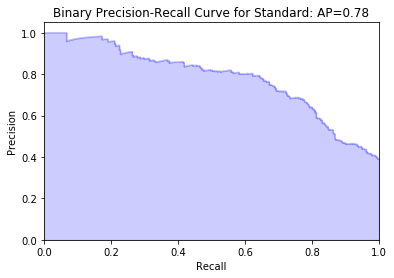

In [25]:
# Plot precision recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

probas_pred = sgd_clf.decision_function(titanic_scaled)
precisions, recalls, thresholds = precision_recall_curve(target, probas_pred)
average_precision = average_precision_score(target, probas_pred)

# plot the curve
plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall Curve for Standard: AP={0:0.2f}'.format(average_precision))
plt.show()

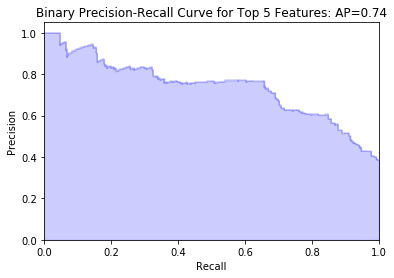

In [26]:
# plot precision-recall curve for top 5
probas_pred = sgd_clf_top5.decision_function(titanic_top5_f)
precisions, recalls, thresholds = precision_recall_curve(target, probas_pred)
average_precision = average_precision_score(target, probas_pred)

# plot the curve
plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall Curve for Top 5 Features: AP={0:0.2f}'.format(average_precision))
plt.show()

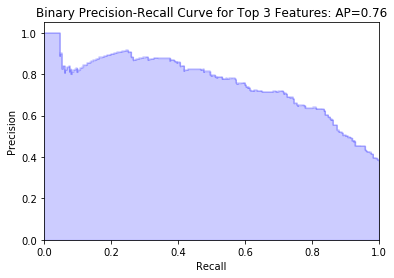

In [27]:
# plot precision-recall curve for top 3
probas_pred = sgd_clf_top3.decision_function(titanic_top3_f)
precisions, recalls, thresholds = precision_recall_curve(target, probas_pred)
average_precision = average_precision_score(target, probas_pred)

# plot the curve
plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall Curve for Top 3 Features: AP={0:0.2f}'.format(average_precision))
plt.show()

In [28]:
# Logistic Regression Modeling
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42)
log_reg.fit(titanic_scaled, target)
log_reg_top5 = LogisticRegression(random_state=42)
log_reg_top5.fit(titanic_top5_f, target)
log_reg_top3 = LogisticRegression(random_state=42)
log_reg_top3.fit(titanic_top3_f, target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
# generate cross-validation scores
scores_log = cross_val_score(log_reg, titanic_scaled, target, cv=20)
scores_log_top5 = cross_val_score(log_reg_top5, titanic_top5_f, target, cv=20)
scores_log_top3 = cross_val_score(log_reg_top3, titanic_top3_f, target, cv=20)

# scores of cross-validation
print('Scores for train set with all features!')
display_scores(scores_log)

print('Scores for train set with top 5 features!')
display_scores(scores_log_top5)

print('Scores for train set with top 3 features!')
display_scores(scores_log_top3)

# standard with all features appears to have better accuracy

Scores for train set with all features!
Scores: [0.73913043 0.84782609 0.73333333 0.82222222 0.75555556 0.77777778
 0.8        0.84444444 0.82222222 0.79545455 0.77272727 0.75
 0.70454545 0.81818182 0.79545455 0.81818182 0.79545455 0.81818182
 0.79545455 0.84090909]
Mean: 0.7923528765920069
Standard deviation: 0.03860227819053305

Scores for train set with top 5 features!
Scores: [0.7173913  0.82608696 0.75555556 0.75555556 0.77777778 0.75555556
 0.75555556 0.88888889 0.8        0.77272727 0.77272727 0.70454545
 0.72727273 0.79545455 0.72727273 0.75       0.77272727 0.77272727
 0.72727273 0.79545455]
Mean: 0.7675274483970136
Standard deviation: 0.040747734790193946

Scores for train set with top 3 features!
Scores: [0.73913043 0.86956522 0.75555556 0.8        0.77777778 0.75555556
 0.8        0.88888889 0.82222222 0.77272727 0.77272727 0.72727273
 0.75       0.79545455 0.75       0.75       0.79545455 0.81818182
 0.72727273 0.79545455]
Mean: 0.7831620553359684
Standard deviation: 0.042

In [30]:
titanic_pred_log = cross_val_predict(log_reg, titanic_scaled, target, cv=20)
titanic_pred_log_top5 = cross_val_predict(log_reg_top5, titanic_top5_f, target, cv=20)
titanic_pred_log_top3 = cross_val_predict(log_reg_top3, titanic_top3_f, target, cv=20)

# print confusion matrix for predictions
print('Standard:')
print(confusion_matrix(target, titanic_pred_log))
print()

print('Top 5 features:')
print(confusion_matrix(target, titanic_pred_log_top5))
print()

print('Top 3 features:')
print(confusion_matrix(target, titanic_pred_log_top3))
print()

# It now looks like Top 5 seems to perform slightly better than Top 3

# Precision and Recall scores
print('Standard:')
print('precision score:', precision_score(target, titanic_pred_log))
print('recall score:', recall_score(target, titanic_pred_log))
print('f1 score:', f1_score(target, titanic_pred_log))
print()

print('Top 5 features:')
print('precision score:', precision_score(target, titanic_pred_log_top5))
print('recall score:', recall_score(target, titanic_pred_log_top5))
print('f1 score:', f1_score(target, titanic_pred_log_top5))
print()

print('Top 3 features:')
print('precision score:', precision_score(target, titanic_pred_log_top3))
print('recall score:', recall_score(target, titanic_pred_log_top3))
print('f1 score:', f1_score(target, titanic_pred_log_top3))
print()

# Again standard seems to be faring better with Logistic Regression

Standard:
[[467  82]
 [103 239]]

Top 5 features:
[[444 105]
 [102 240]]

Top 3 features:
[[465  84]
 [109 233]]

Standard:
precision score: 0.7445482866043613
recall score: 0.6988304093567251
f1 score: 0.7209653092006033

Top 5 features:
precision score: 0.6956521739130435
recall score: 0.7017543859649122
f1 score: 0.6986899563318777

Top 3 features:
precision score: 0.7350157728706624
recall score: 0.6812865497076024
f1 score: 0.7071320182094082



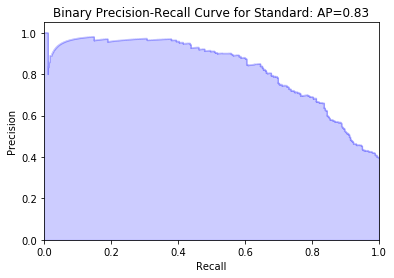

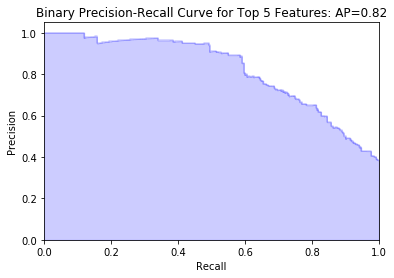

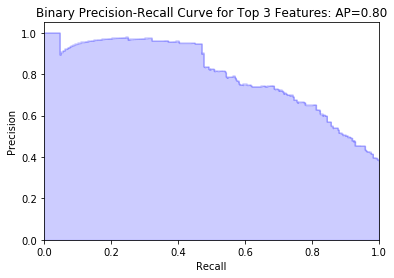

In [31]:
probas_pred = log_reg.decision_function(titanic_scaled)
precisions, recalls, thresholds = precision_recall_curve(target, probas_pred)
average_precision = average_precision_score(target, probas_pred)

# plot the curve
plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall Curve for Standard: AP={0:0.2f}'.format(average_precision))
plt.show()

# plot precision-recall curve for top 5
probas_pred = log_reg_top5.decision_function(titanic_top5_f)
precisions, recalls, thresholds = precision_recall_curve(target, probas_pred)
average_precision = average_precision_score(target, probas_pred)

# plot the curve
plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall Curve for Top 5 Features: AP={0:0.2f}'.format(average_precision))
plt.show()

# plot precision-recall curve for top 3
probas_pred = log_reg_top3.decision_function(titanic_top3_f)
precisions, recalls, thresholds = precision_recall_curve(target, probas_pred)
average_precision = average_precision_score(target, probas_pred)

# plot the curve
plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall Curve for Top 3 Features: AP={0:0.2f}'.format(average_precision))
plt.show()

In [32]:
# TODO - build out transformation pipelines then test out.
# See sklearn.pipeline

# Next models to test out: Random forest classifiers, naive Bayes, support verctor machine, and linear classifiers